# Plug-and-Play Image Restoration

<a target="_blank" href="https://colab.research.google.com/github/esoubies/TP_INSA/blob/master/TP_1_Image_PnP_Unroll.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This practical session is dedicated to the implementation of plug-and-play algorithms with pre-learned denoisers.
They will be illustrated on deblurring problems using deepinv library.

The outline of the session is:
1. Coding a blur model and testing a pretrained denoiser
2. Implementing a PnP PGD
3. Implementing a PnP HQS

Practical informations:
1. In torch the image format is B x C x H x W where
  - B is the batch size
  - C is the number of channels (C=1 for grayscale C = 3 for RGB)
  - H is the number of pixels in the vertical direction
  - W is the number of pixels in the horizontal direction
2. To take advantage of the GPU acceleration, make sure to pass the `device` variable to the torch functions. For example,
`x = torch.zeros((1,1,25,25))` creates an image of size (1,1,25,25) on the cpu than can be transfered to the GPU using `x = x.to('cuda')`.
The image can directly by created on the GPU using `x = torch.zeros((1,1,25,25), device = 'cuda')`
In the following code block, the variable `device` is created to easily swith from CPU to GPU. You can use it in your code instead of hard coding 'cpu' 'cuda'.

In [1]:
import numpy as np
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift

import matplotlib.pyplot as plt
import time

import torch
print(torch.__version__)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

!pip install git+https://github.com/deepinv/deepinv.git
import deepinv as dinv
from deepinv.physics.generator import MotionBlurGenerator

psnr = dinv.loss.PSNR()

2.9.0+cu126
cuda
  Cloning https://github.com/deepinv/deepinv.git to /tmp/pip-req-build-gblr300o
  Running command git clone --filter=blob:none --quiet https://github.com/deepinv/deepinv.git /tmp/pip-req-build-gblr300o
  Resolved https://github.com/deepinv/deepinv.git to commit 914d39ed80449858b6a14b94a5932250553ea46b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.1 MB/s eta 0:00:00
  Created wheel for deepinv: filename=deepinv-0.3.7-py3-none-any.whl size=868930 sha256=48fedd422a747bc090e875fc03e1fb276bd9e4f0e968248f178f8ca5e8d31ec0
  Stored in directory: /tmp/pip-ephem-wheel-cache-syk0gfo4/wheels/84/8d/78/3f46551e7c8c141353bd628df44fbeb33820f3b5a4a2da7e2a
Successfully built deepinv


<br/><br/><br/>

# Part 1: Blur model and pretrained denoiser

## Test a pre-learned denoiser

In this section, we load an image and pretrained denoiser from the deepinv library. The denoiser is tested on a denoising problem.


torch.Size([1, 3, 256, 256])


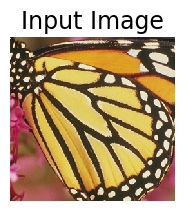

In [2]:
## Open the image
url = dinv.utils.demo.get_image_url("butterfly.png") # Other images are available here : https://huggingface.co/datasets/deepinv/images
x0 = dinv.utils.demo.load_url_image(url, grayscale=False).to(device)
x0_shape = x0.shape
print(x0_shape)

# Plot image
dinv.utils.plot(x0,'Input Image')

There are three possible denoisers in deepinv: DRUnet, DnCNN, TV.
You can select one by commenting/decommenting the appropriate lines and play with the three during the session.

In [3]:

# Load the DRUNet denoiser
# https://deepinv.github.io/deepinv/stubs/deepinv.models.DRUNet.html
D = dinv.models.DRUNet(pretrained='download').to(device)


# Load the DnCNN denoiser (WARNING: the proposed weights are only trained for noise level sigma = 2/255)
# https://deepinv.github.io/deepinv/stubs/deepinv.models.DnCNN.html
#D = dinv.models.DnCNN(pretrained='download').to(device)

# TV denoiser (only in last version of deepinv)
#Dtv = dinv.models.TVDenoiser().to(device)
#def D(x,sigma):
#  return Dtv(x,ths=2*sigma**2)



Downloading: "https://huggingface.co/deepinv/drunet/resolve/main/drunet_deepinv_color_finetune_22k.pth?download=true" to /root/.cache/torch/hub/checkpoints/drunet_deepinv_color_finetune_22k.pth


100%|██████████| 125M/125M [00:01<00:00, 70.4MB/s]


**Compute** a noisy image
$$ y = x_0 + \xi $$
where $\xi \sim \mathcal{N}(0,\sigma^2 \mathsf{Id})$.

Denoise the image $y$ by using a pre-learned denoiser for different level of noise $\sigma^2$.

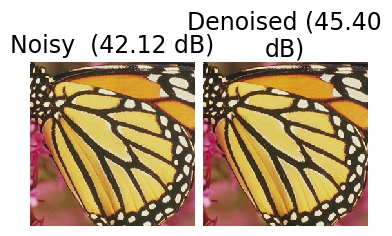

In [4]:
sigma = 2/255 # in [0, 0.2]
y = x0 + sigma*torch.randn_like(x0) # on genere un bruit gaussien
Dy = D(y,sigma)

dinv.utils.plot([y,Dy],['Noisy  (%.2f dB)'%psnr(x0,y),'Denoised (%.2f dB)'%psnr(x0,Dy)])

## Blur model

This section generates a motion blur kernel from the deepinv library.

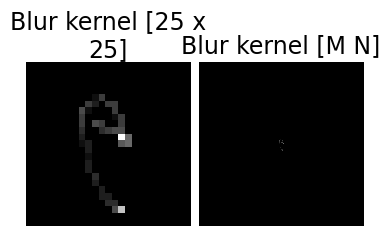

In [5]:
## Generate a motion blur
torch.manual_seed(1)  # fix random seed for reproducibility
generator = MotionBlurGenerator((25, 25), num_channels=1, sigma = 0.5)
blur = generator.step(seed = 1)
kt = blur['filter'] #petite image 25x25 qui représenta la "forme" du flou

# Embed the kernel in a MxNx3 image, and put center at pixel (0,0)
# on prepare le noyau pour pouvoir flouter une image 256x256 RGB avec des FFT
k = torch.zeros_like(x0)
m,n = kt.shape[-2:]
k[:,:,0:m,0:n] = kt/torch.sum(kt)
k = torch.roll(k,(-int(m/2),-int(n/2)),(-2,-1))

# Display kernel
dinv.utils.plot([kt, fftshift(k,dim=(-2,-1))],['Blur kernel [25 x 25]','Blur kernel [M N]'])


The forward model is:
$$ y = k \star x_0 + \xi $$
where $\xi \sim \mathcal{N}(0,\sigma^2 \mathsf{Id})$ and $k$ is the generated blur kernel.

Implement the code generating $y$ using the Fast Fourier Transform. (You can look at the documentation of `torch.fft.fft2`)

In [6]:
print(x0.shape[:],k.shape[:])

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


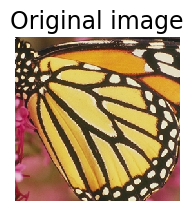

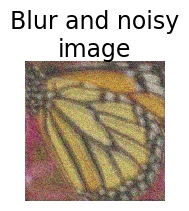

In [12]:
sigma = 0.1 #2/255  # noise level

# Draw a sample of the direct model for image deblurring (apply blur and add Gaussian noise)
blurred = torch.fft.ifft2(torch.fft.fft2(k) * torch.fft.fft2(x0)).real
y = blurred + sigma * torch.randn_like(x0) # on ajoute un bruit independant pour chaque pixel, de la meme forme que l'image (1,3,H,W)

dinv.utils.plot(x0,'Original image')
dinv.utils.plot(y,'Blur and noisy image')

# Part 2: Image deblurring with PnP-PGD

In this section, you will implement a PnP proximal gradient descent (PnP-PGD) to solve the deblurring problem. The iteration is given by :
$$ x_{k+1} = D_\eta \circ (\operatorname{Id} - \tau \nabla f) (x_k) $$
where
- $f$ is the data fidelity term defined by $f(x) = \frac{1}{2\sigma^2} \|k \star x - y\|_2^2$.
- $D_\eta$ is the denoiser of level $\eta$
- $\tau$ is the step-size and should be chosen such that $\tau < \frac{2}{L}$ with $L$ the Lipschitz constant of $\nabla f$.

Complete the following cell to
1. Implement PnP-PGD iteration
2. Store the PSNR of the reconstruction at each iteration

Try to find the best $\tau$ and $\eta$ and number of iterations. Test the other denoisers and comment.

torch.Size([1, 3, 256, 256])
[   0/ 100] [0.00000 s] PSNR = 14.30
[  10/ 100] [0.33154 s] PSNR = 21.44


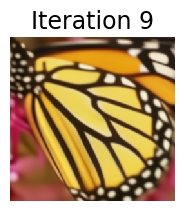

[  20/ 100] [0.91844 s] PSNR = 22.93


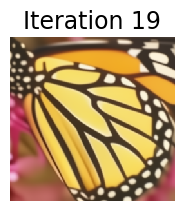

[  30/ 100] [1.50068 s] PSNR = 23.50


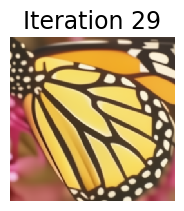

[  40/ 100] [2.11167 s] PSNR = 23.69


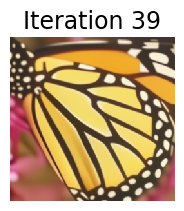

[  50/ 100] [2.71447 s] PSNR = 23.75


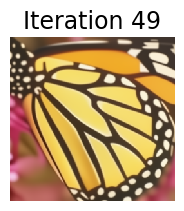

[  60/ 100] [3.32446 s] PSNR = 23.78


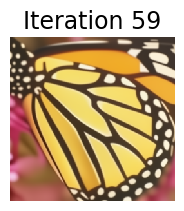

[  70/ 100] [3.90940 s] PSNR = 23.81


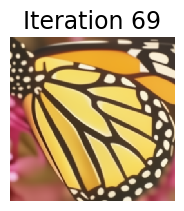

[  80/ 100] [4.50215 s] PSNR = 23.82


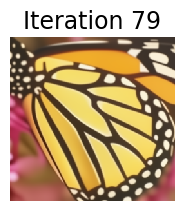

[  90/ 100] [5.30187 s] PSNR = 23.83


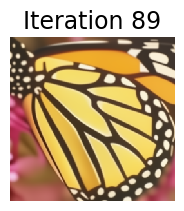

[ 100/ 100] [5.88822 s] PSNR = 23.84


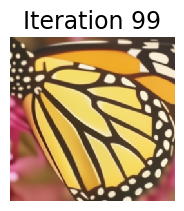

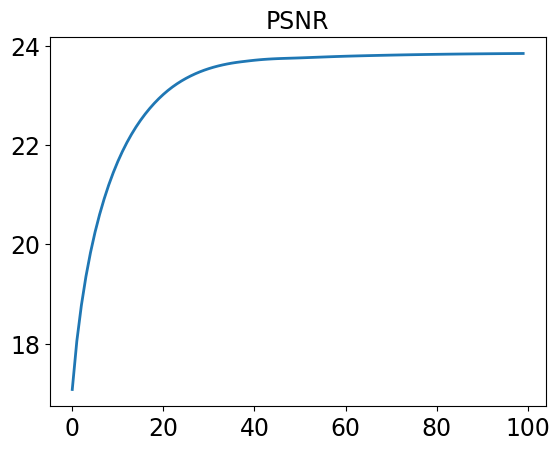

In [15]:
tau =  0.01 # step-size
eta =  0.1 # strength of the denoiser
sigma = 0.1

# initialize with blurry image
x = y.clone()
print(x.shape[:])

psnrtab = []  # to store psnr
K = torch.fft.fft2(k) # Fk : transformee de fourier du motion blur k
K_conj = torch.conj(K)  # apparait dans le calcul de A*
Yf = torch.fft.fft2(y) # Fy

niter =  100 # number of iterations
t0 = time.time()
print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(0,niter,0.,psnr(x0,y)))

for it in range(niter):
    # before calling the denoiser, use with torch.no_grad() to avoid computing the gradient with respect to the weights of the denoising network
    Xf = torch.fft.fft2(x) # Fx
    grad_f = torch.fft.ifft2(K_conj * (K*Xf - Yf)).real / (sigma**2) # A* (Ax-y) / sigma^2
    diff = x - tau * grad_f # pas de gradient

    # debruitage, etape PnP
    with torch.no_grad():
      x = D(diff,eta) #xk+1 = D(x_k - tau*grad_f(x_k))
    psnrtab.append(psnr(x0,x))

    if (it+1)%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(it+1,niter,time.time()-t0,psnrtab[it]))
        dinv.utils.plot(x,'Iteration %i'%it)

plt.plot(torch.tensor(psnrtab))
plt.title('PSNR')
plt.show()
# print(psnrtab)

# Part 3: Image deblurring with PnP-HQS

In this section, you will implement a PnP Half Quadratic Splitting (PnP-HQS) to solve the deblurring problem. The iteration is given by :
$$ x_{k+1} = D_{\eta} \circ \mathsf{Prox}_{\tau f} (x_k) $$
where
- $f$ is the data fidelity term defined by $f(x) = \frac{1}{2\sigma^2} \|k \star x - y\|_2^2$.
- $D_\eta$ is the denoiser of level $\eta$
- $\tau$ is the penalty parameter



Before coding the PnP-HQS, we advise to create a function that implements the proximal operator of the data-fidelity term:
$$\mathsf{Prox}_{\tau f}(x) = \left(\frac{1}{\sigma^2} A^T A + \tau \mathsf{Id} \right)^{-1} \left( \frac{1}{\sigma^2} A^T y + \tau x \right) .$$

In [21]:
def proxf(x, tau, sigma, fAtA, fAty):
  Xf = torch.fft.fft2(x)
  denominateur = (fAtA / (sigma**2)) + tau + 1e-16
  numerateur = (fAty / (sigma**2)) + tau*Xf
  Zf = numerateur / denominateur
  return torch.fft.ifft2(Zf).real


Complete the following cell to
1. Implement PnP-HQS iteration
2. Store the PSNR of the reconstruction at each iteration

Try to find the best $\tau$ and $\eta$ and number of iterations. Test the other denoisers and comment.

[   0/  50] [0.00000 s] PSNR = 14.30
[  10/  50] [0.24582 s] PSNR = 24.86


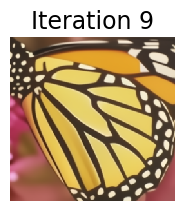

[  20/  50] [0.78982 s] PSNR = 24.87


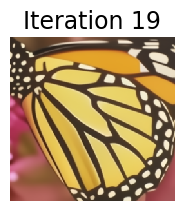

[  30/  50] [1.33459 s] PSNR = 24.87


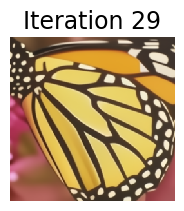

[  40/  50] [1.90492 s] PSNR = 24.88


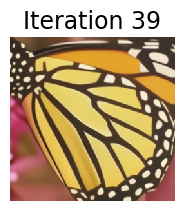

[  50/  50] [2.46843 s] PSNR = 24.88


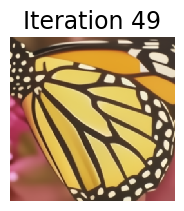

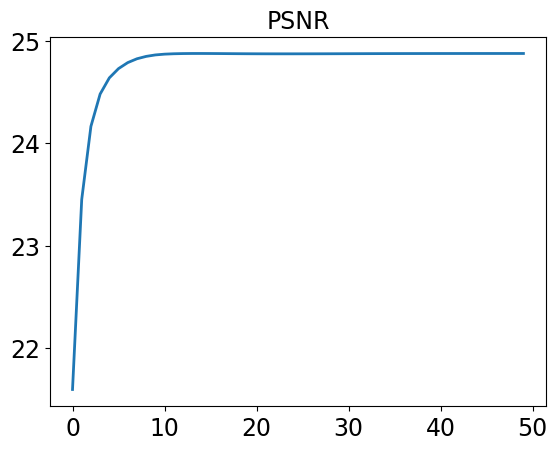

In [36]:
tau = 5  # penalty parameter
eta = 0.3 # strength of the denoiser
sigma = 0.1

# initialize with blurry image
x = y.clone()

psnrtab = []  # to store psnr
rtab = []     # to store residual

K = torch.fft.fft2(k) # Fk
fAtA = (K.abs()**2) # A* A
fAty = torch.conj(K) * torch.fft.fft2(y) # A* y

niter = 50 # number of iteration
t0 = time.time()
print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(0,niter,0.,psnr(x0,y)))

for it in range(niter):
  with torch.no_grad():
    # prox de f
    z = proxf(x, tau=tau, sigma=sigma,fAtA=fAtA, fAty=fAty)

    # HQS iteration
    x = D(z,eta)

    psnrtab.append(psnr(x0,x))

    if (it+1)%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(it+1,niter,time.time()-t0,psnrtab[it]))
        dinv.utils.plot(x,'Iteration %i'%it)

plt.plot(torch.tensor(psnrtab))
plt.title('PSNR')
plt.show()